# Exercise 12: Cross Validation
-----

In this exercise, we'll practice implementing cross validation techniques, including leave-one-out and k-fold cross validation. We'll use the `PimaIndiansDiabetes2` practice dataset, which has medical data on a group of Pima Native American women, including whether or not they have diabetes. This dataset is part of the `mlbench` package. We'll be using each person's medical history to predict whether or not they have been diagnosed with diabetes. 

# 1: Data (1 pts)
---

Load the `tidyverse`, `boot`, and `mlbench` packages (you may need to install `boot` and `mlbench`).

Load the `PimaIndiansDiabetes2` dataset using the `data()` function. Drop the `insulin` column (it just has a lot of missing data) and then drop `NA`s from the rest of the dataset. Save your updated dataset to a new variable name. Finally, print the dimensions of your new dataset, and look at the first few lines of data.

In [16]:
# INSERT CODE HERE
#install.packages("boot")
#install.packages("mlbench")

require(boot)
require(mlbench)
require(tidyverse)


data(PimaIndiansDiabetes2)

head(PimaIndiansDiabetes2)

df <- PimaIndiansDiabetes2 %>%
  select(-c(insulin))%>%
  drop_na()

head(df)


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



,pregnant,glucose,pressure,triceps,insulin,mass,pedigree,age,diabetes
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,6,148,72,35,NA,33.6,0.627,50,pos
2,1,85,66,29,NA,26.6,0.351,31,neg
3,8,183,64,NA,NA,23.3,0.672,32,pos
4,1,89,66,23,94,28.1,0.167,21,neg
5,0,137,40,35,168,43.1,2.288,33,pos
6,5,116,74,NA,NA,25.6,0.201,30,neg


,pregnant,glucose,pressure,triceps,mass,pedigree,age,diabetes
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,6,148,72,35,33.6,0.627,50,pos
2,1,85,66,29,26.6,0.351,31,neg
4,1,89,66,23,28.1,0.167,21,neg
5,0,137,40,35,43.1,2.288,33,pos
7,3,78,50,32,31.0,0.248,26,pos
9,2,197,70,45,30.5,0.158,53,pos


(Note that in medical contexts, `pedigree` refers to a system of measuring family history of a condition. So here, higher numbers mean greater family history of diabetes. You can read more about this dataset [here](https://rdrr.io/cran/mlbench/man/PimaIndiansDiabetes.html).)

# 2. Leave-one-out Cross Validation (4 pts)

In the tutorial, we learned how to fit leave-one-out cross validation using the `cv.glm` function from the `boot` package. But we can also do this manually using `predict()` like we have in the past.

Let's predict `diabetes`, a dichotomous outcome, using all the other variables in our modified dataset. 

First, fit a logistic regression model using all of the observations except the very first one. Then use your fitted model to predict whether your holdout case is positive or negative for diabetes. Remember that logistic regression coefficients are in **log-odds**, meaning that if an output is positive, the probability of the outcome is greater than 50%; if the output is negative, the probability of the outcome is less than 50%. 

Compare your result to the actual response in row one above. Did your model correctly classify this observation?

In [17]:
test <- df[1, ]
rownames(test)

train <- df[-1,]

dim(test) 
dim(train)


Diabetes_test=test$diabetes

glm.fit=glm(diabetes~ ., data=train, family=binomial) 

glm.probs=predict(glm.fit, test, type="response")
glm.pred=rep("neg",nrow(test)) 
glm.pred[glm.probs>0.5] = "pos"


confusion_df = data.frame(glm.pred, Diabetes_test) 
colnames(confusion_df) = c('predicted', 'actual')


table(confusion_df)

print(paste("Accuracy:",mean(confusion_df$predicted == confusion_df$actual)))

#Yes, we got the correct classification



[1] "1"

[1] 1 8

[1] 531   8

         actual
predicted neg pos
      pos   0   1

[1] "Accuracy: 1"


So we just calculated a single iteration of LOOCV. We used 531 rows of our data to fit a model to predict the outcome of the last row. 

Below, use a `for` loop to iterate through the rest of your dataset doing the same thing. You will need to:
* Create a data frame `results` with two columns: one named `actual` which holds the true classification for each observation, and one named `predicted`, which should be filled with `NA`s. This is where you'll store the output of your loop.
* Create a loop that runs through each row of your data, pulls that observation out, trains your model on the remaining data, and then tests the fitted model on your test observation.
* Store your model *predictions* ("pos" or "neg" -- not the log-odds) in the `predicted` column of your `results` dataframe

After you run your loop, print the first few lines of `results`.

In [18]:
# Initialize `results` data frame
# INSERT CODE HERE
results <- data.frame(Actual = df$diabetes, Predicted = NA)

#for loop
for (i in 1:nrow(results)){ #don't forget to change this to your data set name
    # separate individual observation `i` from the rest of your data
    # INSERT CODE HERE
    test <- df[i, ]

    train <- df[-i,]
    
    # train your model
    # INSERT CODE HERE
    glm.fit=glm(diabetes~ ., data=train, family=binomial) 

    # test model on hold out observation
    # INSERT CODE HERE
    glm.probs=predict(glm.fit, test, type="response")

    

    # classify model prediction as "pos" or "neg" and add to `results`
    # INSERT CODE HERE
    results[i, "Predicted"] <- rep("neg",nrow(test))
    results[i, "Predicted"][glm.probs>0.5] = "pos"
   
}

head(results)



,Actual,Predicted
,<fct>,<chr>
1,pos,pos
2,neg,neg
3,neg,neg
4,pos,pos
5,pos,neg
6,pos,pos


Now, calculate the overall error of your model. What proportion of cases were incorrectly classified?

In [19]:
# INSERT CODE HERE
print(paste("Accuracy:",mean(results$Predicted == results$Actual)))

#About 78% accuracy

[1] "Accuracy: 0.778195488721805"


# 3. Compare to `cv.glm` (3 pts)

Now, let's compare this result to the `cv.glm` function. Using the tutorial as a guide, use `cv.glm` to run LOOCV on the data, using the same model (i.e., still using all of the variables to predict diabetes diagnosis).

Note that, because this is a `classification` problem and not a regression problem like in the tutorial, we need to adjust the `cost` argument of `cv.glm`. We can read more about this in the docs:

In [30]:
#?cv.glm
set.seed(1)
glm.fit=glm(diabetes~ ., data=df, family=binomial) 

cost <- function(r, pi = 0) mean(abs(r-pi) > 0.5)

cv.err  = cv.glm(df, glm.fit, K=nrow(df), cost = cost)

cv.err$delta 

[1] 0.2218045 0.2221154

Here, we see `cost` is defined as: 
> "A function of two vector arguments specifying the cost function for the cross-validation. The first argument to cost should correspond to the **observed responses** and the second argument should correspond to the **predicted or fitted responses** from the generalized linear model."

In the example code (scroll to bottom of the docs), we see that the appropriate cost function for a binary classification is 

``
cost <- function(r, pi = 0) mean(abs(r-pi) > 0.5)
``

Where `r` is the vector of observed responses (technically "pos" and "neg", but R treats these as 1 and 0 under the hood), and `pi` is the vector of *probabilities* (not log-odds) fit by the model. Thus, this boils down to our error: what proportion of observations were incorrectly classified. You will need to include this code below.

Time difference of 37.58621 secs

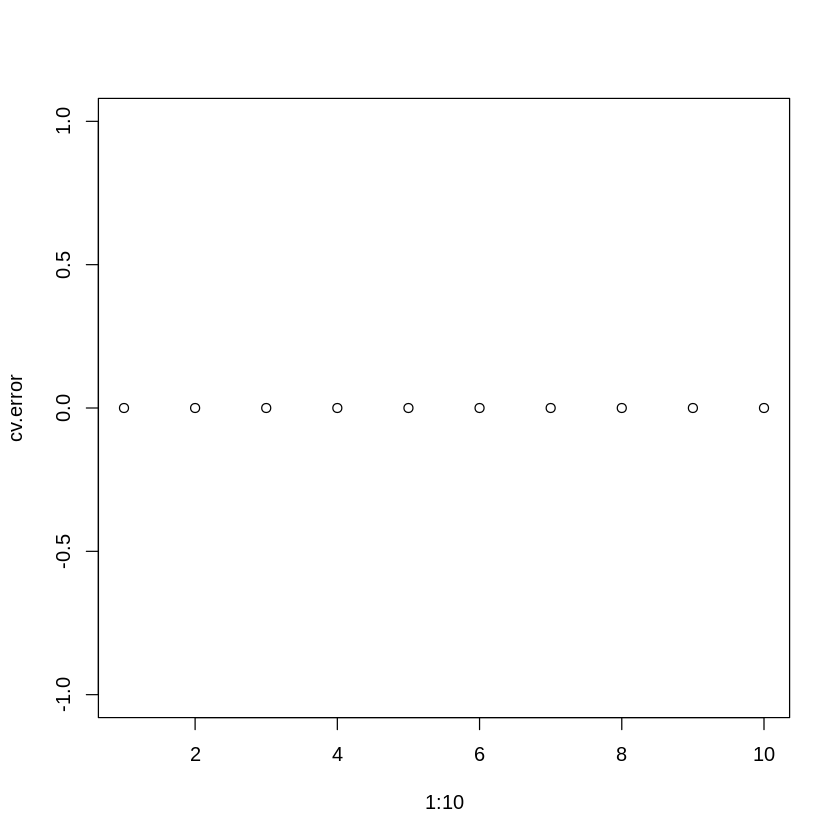

In [26]:
# INSERT CODE HERE
#?cv.glm
set.seed(1)

cv.error = rep(0,10) 
start.time <- Sys.time()
for (i in 1:10) {
    glm.fit=glm(diabetes~ ., data=df, family=binomial) 

    cv.err[i]  = cv.glm(df, glm.fit)$delta[1]
}
end.time <- Sys.time()

LOOtime <- end.time-start.time 
LOOtime

plot(1:10,cv.error) 

How do your results compare to your manual LOOCV above?

> * *Write response here*
>
> They look pretty much the same.


# 4. Adjusting K and Reflection (2 pts)

Recall that LOOCV has some drawbacks. In particular, it has quite high *variance* which can lead to poor performance on new test data. We can reduce this variance by increasing K.

Below, re-run your cross validation using `cv.glm` with `k` set to 3, 5, 10, and 15. 

In [27]:
set.seed(1)
#INSERT CODE BELOW
glm.fit=glm(diabetes~ ., data=df, family=binomial) 

cost <- function(r, pi = 0) mean(abs(r-pi) > 0.5)

# K = 3
cv.err  = cv.glm(df, glm.fit, K=3, cost = cost)
cv.err$delta 

# K = 5
cv.err  = cv.glm(df, glm.fit, K=5, cost = cost)
cv.err$delta 

# K = 10
cv.err  = cv.glm(df, glm.fit, K=10, cost = cost)
cv.err$delta 

# K = 15
cv.err  = cv.glm(df, glm.fit, K=15, cost = cost)
cv.err$delta 

[1] 0.2105263 0.2168085

[1] 0.2161654 0.2184444

[1] 0.2236842 0.2230942

[1] 0.2274436 0.2281856

#### Reflection

How do your errors compare to your LOOCV error above? How do they change as k increases?
> * *Write response here:* Increasing levels of k results in slightly lower error.


If you change the random seed above, you'll get slightly different errors. If you were to do the same with your LOOCV above , would you expect to get different results each time? Why or why not?
> * *Write response here*: No, I would not expect the results to change for LOOCV comapared to smaller k folds. LOOCV is fully exhaustive and because only one is left out the train group generally doesn't change that much. With smaller k folds, you are randomly subsetting k=X times.


**DUE:** 5pm March 27, 2023

**IMPORTANT** Did you collaborate with anyone on this assignment? If so, list their names here.
> *Someone's Name*
> 
>

